In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
# from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import product
import statsmodels.api as sm

from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM  # Updated import paths
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
import tensorflow as tf

from itertools import cycle
import scipy.stats as stats
import seaborn as sns

plt.style.use('seaborn-darkgrid')
import warnings
warnings.filterwarnings("ignore")

C:\Users\Asus\AppData\Local\Temp\ipykernel_17484\3236992082.py:25: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [2]:
df = pd.read_csv('../data/returns_svi_edgar.csv')
df = df[['symbol', 'date', 'svi.1', 'edgar', 'price', 'volume', 'WeeklyReturns']]
df.rename(columns = {'svi.1':'svi'}, inplace=True)
df.head()

,symbol,date,svi,edgar,price,volume,WeeklyReturns
0,MSFT,2005-01-02,31338,145,26.67,398924026.0,NaN
1,MSFT,2005-01-09,33079,3220,26.12,379712121.0,-2.062242
2,MSFT,2005-01-16,20892,3030,25.65,266617523.0,-1.799387
3,MSFT,2005-01-23,34820,3539,26.18,409844550.0,2.066277
4,MSFT,2005-01-30,26115,4112,26.32,347830186.0,0.534759


In [3]:
df['returns'] = df['WeeklyReturns'].apply(lambda x: np.round(x, 0))


In [7]:
df_na = pd.DataFrame(columns = ['symbol','total'])
for s in df['symbol'].unique():
     NAs = df.loc[df['symbol'] == s]['price'].isna().sum()
     df_na.loc[len(df_na)] = {'symbol':s, 'total':NAs}

df_na


,symbol,total
0,MSFT,0
1,AAPL,0
2,NVDA,0
3,AMZN,0
4,GOOG,0
...,...,...
387,PYPL,550
388,VLO,0
389,BA.L,962
390,HUM,0


In [10]:
na_symbols = df_na.loc[df_na['total'] > 0]['symbol'].to_list()

In [14]:
# symbols with na data
for s in na_symbols:
     df = df.loc[df['symbol'] != s]

print(len(df))
print(df['symbol'].nunique())

287638
299


In [22]:
# some prices are zero
minus_symbols = df.loc[df['price']<0]['symbol'].unique()
for s in minus_symbols:
     df = df.loc[df['symbol'] != s]

print(len(df))
print(df['symbol'].nunique())

278980
290


In [23]:
df['WeeklyReturns'] = 0.0  # Initialize the column with zeros

for company in df['symbol'].unique():
    company_mask = df['symbol'] == company
    df.loc[company_mask, 'WeeklyReturns'] = df.loc[company_mask, 'price'].pct_change() * 100

In [27]:
df.reset_index(inplace=True)
df['returns'] = df['WeeklyReturns'].apply(lambda x: np.round(x, 0))

In [45]:
df.to_csv("../data/new_dataset.csv")

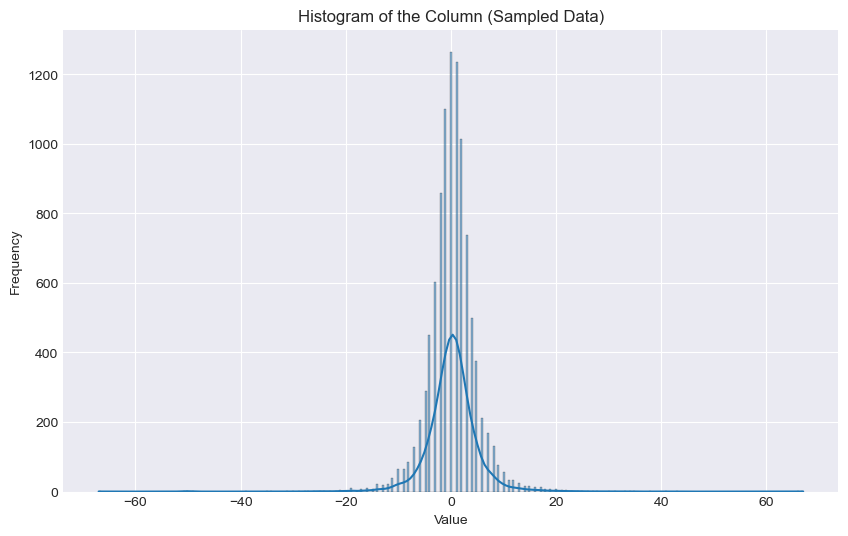

In [42]:

column_data = df['returns']

# Sample a subset of your data
sample_size = min(10000, len(column_data))  # Adjust sample size as desired
column_sample = column_data.sample(n=sample_size, random_state=1)

# Plotting the histogram with the sampled data
plt.figure(figsize=(10, 6))
sns.histplot(column_sample, kde=True)
plt.title('Histogram of the Column (Sampled Data)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


In [38]:
df.loc[(df['returns']>20) | (df['returns']<-20)]

,index,symbol,date,svi,edgar,price,volume,WeeklyReturns,returns
970,970,AAPL,2005-02-27,44120,1521,42.81,1.343104e+08,-51.893471,-52.0
1157,1157,AAPL,2008-09-28,147802,4371,97.07,3.377796e+08,-24.305995,-24.0
1454,1454,AAPL,2014-06-08,145264,89222,91.28,2.931859e+08,-85.860558,-86.0
1779,1779,AAPL,2020-08-30,170600,7538,120.96,1.166973e+09,-75.770687,-76.0
1989,1989,NVDA,2006-04-02,18212,0,30.53,4.539995e+07,-46.681802,-47.0
...,...,...,...,...,...,...,...,...,...
278739,376602,HES,2008-10-26,31500,511,60.21,3.099170e+07,20.564678,21.0
278744,376607,HES,2008-11-30,28875,1802,38.49,3.006420e+07,-28.774981,-29.0
278745,376608,HES,2008-12-07,33250,775,47.70,3.019850e+07,23.928293,24.0
278811,376935,STM,2020-03-15,122721,0,16.42,2.073260e+07,-23.019222,-23.0


In [33]:
df['date'] = pd.to_datetime(df['date'])

In [40]:
test = df.loc[(df['returns']>20) | (df['returns']<-20)]
test = test.loc[test['date'].dt.year >= 2005]
len(test)

1742

In [31]:
df.loc[df['symbol'] == 'AAPL'].tail()

,index,symbol,date,svi,edgar,price,volume,WeeklyReturns,returns
1919,1919,AAPL,2023-05-07,25590,56247,172.57001,249685623.0,-0.576136,-1.0
1920,1920,AAPL,2023-05-14,25590,57743,175.16000,258452789.0,1.500834,2.0
1921,1921,AAPL,2023-05-21,25590,45344,175.42999,250258640.0,0.154139,0.0
1922,1922,AAPL,2023-05-28,27296,45063,180.95000,286095295.0,3.146560,3.0
1923,1923,AAPL,2023-06-04,44356,158695,180.96001,348117069.0,0.005532,0.0


In [30]:
df[969:973]

,index,symbol,date,svi,edgar,price,volume,WeeklyReturns,returns
969,969,AAPL,2005-02-20,35296,1921,88.99,89615748.0,2.511231,3.0
970,970,AAPL,2005-02-27,44120,1521,42.81,134310408.0,-51.893471,-52.0
971,971,AAPL,2005-03-06,30884,1909,40.27,150452794.0,-5.933193,-6.0
972,972,AAPL,2005-03-13,26472,2410,42.96,129461707.0,6.679911,7.0


In [6]:
# Getting specific quartiles
Q1 = column_data.quantile(0.25)
Q2 = column_data.quantile(0.5)  # Median
Q3 = column_data.quantile(0.75)

print(f"1st Quartile (Q1): {Q1}")
print(f"Median (Q2): {Q2}")
print(f"3rd Quartile (Q3): {Q3}")

1st Quartile (Q1): -2.0
Median (Q2): -0.0
3rd Quartile (Q3): 2.0


In [7]:
# labeling returns
def labeling(r):
     if r == 0:
          l = 0
     elif r > 0:
          if r <= 2:
               l = 1
          else : 
               l = 2

     elif r < 0:
          if r >= -2:
               l = 3
          else : 
               l = 4
     else:
          l = None
     return l

df['labeled_returns'] = df['returns'].apply(labeling)

          

In [13]:
def lagger(df, col,num):
    df[f'shifted-({num})']  = df[col].shift(num)
    return df

def ticker_initialization(symbol, lag):
     df_symbol = df.loc[df['symbol'] == symbol]
     df_symbol = lagger(df_symbol, 'labeled_returns', -lag)
     
     start = 0
     end = len(df_symbol) - lag
     df_symbol = df_symbol[start:end]
     df_symbol.reset_index(inplace = True)

     return df_symbol

def standardize(column):
    mean_value = column.mean()
    std_dev = column.std()
    scaled_column = (column - mean_value) / std_dev
    return scaled_column




In [14]:
x

NameError: name 'x' is not defined

In [31]:
# creating batches and test, train size
Xs, ys = [], []
for t in df['symbol'].unique():
     lag = 1
     x = ticker_initialization(t , lag)
     x['input-1'] = standardize(x['svi'])
     x['input-2'] = standardize(x['edgar'])
     x['output'] = x[f'shifted-(-{lag})']

     X = x[['input-1', 'input-2']]
     y = x['output']
     time_steps = 2
     
     for i in range(len(X) - time_steps):
          x_array = X.iloc[i:(i + time_steps)].values
          y_array = y.iloc[i + time_steps]
          if not np.isnan(x_array).any():
               if not np.isnan(y_array).any() :
                    Xs.append(x_array)
                    ys.append(y_array)

X_train, X_test, y_train, y_test = train_test_split(np.array(Xs), np.array(ys), test_size=0.20, shuffle=False)

print(X_train.shape, y_train.shape)

(244840, 2, 2) (244840,)


Epoch 1/3
245/245 [==============================] - 9s 22ms/step - loss: 1.5930 - accuracy: 0.2402 - val_loss: 1.5715 - val_accuracy: 0.2746
Epoch 2/3
245/245 [==============================] - 5s 19ms/step - loss: 1.5916 - accuracy: 0.2441 - val_loss: 1.5719 - val_accuracy: 0.2731
Epoch 3/3
245/245 [==============================] - 5s 19ms/step - loss: 1.5908 - accuracy: 0.2456 - val_loss: 1.5711 - val_accuracy: 0.2716


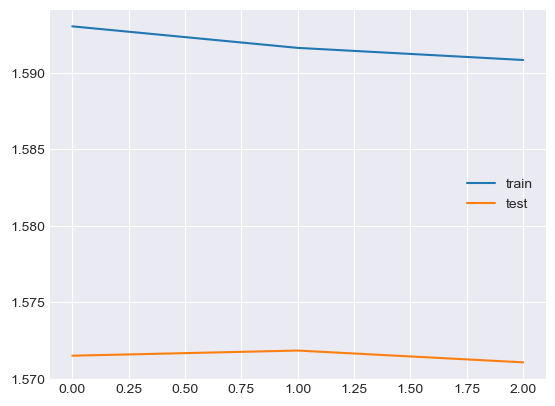

In [33]:


# Assuming your labels are integer encoded, convert them to one-hot
y_train_onehot = to_categorical(y_train, num_classes=5)
y_test_onehot = to_categorical(y_test, num_classes=5)

# number_of_features is the number of features in your input data
number_of_features = X.shape[1]

# Adjust the model for multiclass classification
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, number_of_features)),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(5, activation='softmax')  # Change for multiclass classification
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model using the one-hot encoded labels
history = model.fit(X_train, y_train_onehot, epochs=3, batch_size=1000,
                    validation_data=(X_test, y_test_onehot),
                    verbose=1, shuffle=False, callbacks=[early_stopping])

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()







In [29]:
results = []
results.append({'acc':123, 'time_steps': 123})
results

[{'acc': 123, 'time_steps': 123}]

In [39]:

# results = []
for tl in np.arange(16,25,1):
     Xs, ys = [], []
     for t in df['symbol'].unique():
          lag = 1
          x = ticker_initialization(t , lag)
          x['input-1'] = standardize(x['svi'])
          x['input-2'] = standardize(x['edgar'])
          x['output'] = x[f'shifted-(-{lag})']

          X = x[['input-1', 'input-2']]
          y = x['output']
          time_steps = tl
          
          for i in range(len(X) - time_steps):
               x_array = X.iloc[i:(i + time_steps)].values
               y_array = y.iloc[i + time_steps]
               if not np.isnan(x_array).any():
                    if not np.isnan(y_array).any() :
                         Xs.append(x_array)
                         ys.append(y_array)

     X_train, X_test, y_train, y_test = train_test_split(np.array(Xs), np.array(ys), test_size=0.20, shuffle=False)

     y_train_onehot = to_categorical(y_train, num_classes=5)
     y_test_onehot = to_categorical(y_test, num_classes=5)

     # number_of_features is the number of features in your input data
     number_of_features = X.shape[1]

     # Adjust the model for multiclass classification
     model = Sequential([
     LSTM(50, return_sequences=True, input_shape=(tl, number_of_features)),
     Dropout(0.2),
     LSTM(100, return_sequences=False),
     Dropout(0.2),
     Dense(50, activation='relu'),
     Dense(5, activation='softmax')  # Change for multiclass classification
     ])
     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

     early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

     # Fit the model using the one-hot encoded labels
     history = model.fit(X_train, y_train_onehot, epochs=3, batch_size=1000,
                         validation_data=(X_test, y_test_onehot),
                         verbose=1, shuffle=False, callbacks=[early_stopping])
     acc = history.history['val_accuracy'][-1]
     print(acc)
     results.append({'acc':acc, 'time_steps': tl})

Epoch 1/3
242/242 [==============================] - 32s 116ms/step - loss: 1.5920 - accuracy: 0.2450 - val_loss: 1.5643 - val_accuracy: 0.2761
Epoch 2/3
242/242 [==============================] - 28s 115ms/step - loss: 1.5908 - accuracy: 0.2492 - val_loss: 1.5683 - val_accuracy: 0.2753
Epoch 3/3
242/242 [==============================] - 27s 112ms/step - loss: 1.5900 - accuracy: 0.2501 - val_loss: 1.5679 - val_accuracy: 0.2741
0.2740858495235443
Epoch 1/3
242/242 [==============================] - 34s 127ms/step - loss: 1.5925 - accuracy: 0.2427 - val_loss: 1.5668 - val_accuracy: 0.2730
Epoch 2/3
242/242 [==============================] - 28s 116ms/step - loss: 1.5912 - accuracy: 0.2472 - val_loss: 1.5674 - val_accuracy: 0.2752
Epoch 3/3
242/242 [==============================] - 26s 109ms/step - loss: 1.5906 - accuracy: 0.2486 - val_loss: 1.5688 - val_accuracy: 0.2736
0.2735670804977417
Epoch 1/3
241/241 [==============================] - 34s 128ms/step - loss: 1.5926 - accuracy: 0.2

In [40]:
results

[{'acc': 0.2714589238166809, 'time_steps': 2},
 {'acc': 0.27156174182891846, 'time_steps': 3},
 {'acc': 0.2733061611652374, 'time_steps': 4},
 {'acc': 0.27207183837890625, 'time_steps': 5},
 {'acc': 0.2734266221523285, 'time_steps': 6},
 {'acc': 0.27332282066345215, 'time_steps': 7},
 {'acc': 0.27441859245300293, 'time_steps': 8},
 {'acc': 0.27429914474487305, 'time_steps': 9},
 {'acc': 0.27386656403541565, 'time_steps': 10},
 {'acc': 0.2753453552722931, 'time_steps': 11},
 {'acc': 0.2750449776649475, 'time_steps': 12},
 {'acc': 0.27419888973236084, 'time_steps': 13},
 {'acc': 0.2769060432910919, 'time_steps': 14},
 {'acc': 0.2757952809333801, 'time_steps': 15},
 {'acc': 0.2740858495235443, 'time_steps': 16},
 {'acc': 0.2735670804977417, 'time_steps': 17},
 {'acc': 0.2737278938293457, 'time_steps': 18},
 {'acc': 0.27216073870658875, 'time_steps': 19},
 {'acc': 0.2743166983127594, 'time_steps': 20},
 {'acc': 0.27566108107566833, 'time_steps': 21},
 {'acc': 0.2755579948425293, 'time_step

In [41]:
# labeling returns
def labeling_2(r):
     if r == 0:
          l = 0
     elif r > 0:
          l = 1
     elif r < 0:
          l = 2
     else:
          l = None
     return l

df['labeled_returns'] = df['returns'].apply(labeling_2)


# results = []
for tl in np.arange(2,16,1):
     Xs, ys = [], []
     for t in df['symbol'].unique():
          lag = 1
          x = ticker_initialization(t , lag)
          x['input-1'] = standardize(x['svi'])
          x['input-2'] = standardize(x['edgar'])
          x['output'] = x[f'shifted-(-{lag})']

          X = x[['input-1', 'input-2']]
          y = x['output']
          time_steps = tl
          
          for i in range(len(X) - time_steps):
               x_array = X.iloc[i:(i + time_steps)].values
               y_array = y.iloc[i + time_steps]
               if not np.isnan(x_array).any():
                    if not np.isnan(y_array).any() :
                         Xs.append(x_array)
                         ys.append(y_array)

     X_train, X_test, y_train, y_test = train_test_split(np.array(Xs), np.array(ys), test_size=0.20, shuffle=False)

     y_train_onehot = to_categorical(y_train, num_classes=5)
     y_test_onehot = to_categorical(y_test, num_classes=5)

     # number_of_features is the number of features in your input data
     number_of_features = X.shape[1]

     # Adjust the model for multiclass classification
     model = Sequential([
     LSTM(50, return_sequences=True, input_shape=(tl, number_of_features)),
     Dropout(0.2),
     LSTM(100, return_sequences=False),
     Dropout(0.2),
     Dense(50, activation='relu'),
     Dense(5, activation='softmax')  # Change for multiclass classification
     ])
     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

     early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

     # Fit the model using the one-hot encoded labels
     history = model.fit(X_train, y_train_onehot, epochs=3, batch_size=1000,
                         validation_data=(X_test, y_test_onehot),
                         verbose=1, shuffle=False, callbacks=[early_stopping])
     acc = history.history['val_accuracy'][-1]
     print(acc)
     results.append({'acc':acc, 'time_steps': tl, 'new':123})

Epoch 1/3
245/245 [==============================] - 10s 25ms/step - loss: 1.0762 - accuracy: 0.4504 - val_loss: 0.9713 - val_accuracy: 0.4283
Epoch 2/3
245/245 [==============================] - 5s 22ms/step - loss: 0.9954 - accuracy: 0.4627 - val_loss: 0.9704 - val_accuracy: 0.4283
Epoch 3/3
245/245 [==============================] - 5s 21ms/step - loss: 0.9947 - accuracy: 0.4636 - val_loss: 0.9703 - val_accuracy: 0.4283
0.42834505438804626
Epoch 1/3
245/245 [==============================] - 11s 30ms/step - loss: 1.0680 - accuracy: 0.4577 - val_loss: 0.9699 - val_accuracy: 0.4284
Epoch 2/3
245/245 [==============================] - 7s 29ms/step - loss: 0.9959 - accuracy: 0.4620 - val_loss: 0.9695 - val_accuracy: 0.4284
Epoch 3/3
245/245 [==============================] - 7s 27ms/step - loss: 0.9950 - accuracy: 0.4632 - val_loss: 0.9691 - val_accuracy: 0.4284
0.428372859954834
Epoch 1/3
245/245 [==============================] - 14s 40ms/step - loss: 1.0609 - accuracy: 0.4527 - val_l

In [24]:
# labeling returns
def labeling_2(r):
     if r == 0:
          l = 0
     elif r > 0:
          l = 1
     elif r < 0:
          l = 2
     else:
          l = None
     return l

df['labeled_returns'] = df['returns'].apply(labeling_2)


# results = []
for tl in np.arange(16,17,1):
     Xs, ys = [], []
     for t in df['symbol'].unique():
          lag = 1
          x = ticker_initialization(t , lag)
          x['input-1'] = standardize(x['svi'])
          x['input-2'] = standardize(x['edgar'])
          x['output'] = x[f'shifted-(-{lag})']

          X = x[['input-1', 'input-2']]
          y = x['output']
          time_steps = tl
          
          for i in range(len(X) - time_steps):
               x_array = X.iloc[i:(i + time_steps)].values
               y_array = y.iloc[i + time_steps]
               if not np.isnan(x_array).any():
                    if not np.isnan(y_array).any() :
                         Xs.append(x_array)
                         ys.append(y_array)

     X_train, X_test, y_train, y_test = train_test_split(np.array(Xs), np.array(ys), test_size=0.20, shuffle=False)

     y_train_onehot = to_categorical(y_train, num_classes=3)
     y_test_onehot = to_categorical(y_test, num_classes=3)

     # number_of_features is the number of features in your input data
     number_of_features = X.shape[1]

     # Adjust the model for multiclass classification
     model = Sequential([
     LSTM(50, return_sequences=True, input_shape=(tl, number_of_features)),
     Dropout(0.2),
     LSTM(100, return_sequences=False),
     Dropout(0.2),
     Dense(50, activation='relu'),
     Dense(3, activation='softmax')  # Change for multiclass classification
     ])
     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

     early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

     # Fit the model using the one-hot encoded labels
     history = model.fit(X_train, y_train_onehot, epochs=3, batch_size=1000,
                         validation_data=(X_test, y_test_onehot),
                         verbose=1, shuffle=False, callbacks=[early_stopping])
     acc = history.history['val_accuracy'][-1]
     print(acc)
     results.append({'acc':acc, 'time_steps': tl, 'new':123})

Epoch 1/3
242/242 [==============================] - 24s 81ms/step - loss: 0.9982 - accuracy: 0.4640 - val_loss: 0.9669 - val_accuracy: 0.4457
Epoch 2/3
242/242 [==============================] - 19s 78ms/step - loss: 0.9934 - accuracy: 0.4645 - val_loss: 0.9658 - val_accuracy: 0.4542
Epoch 3/3
242/242 [==============================] - 19s 78ms/step - loss: 0.9927 - accuracy: 0.4650 - val_loss: 0.9654 - val_accuracy: 0.4596
0.45956557989120483


In [44]:
np.save('results-checkpoint', results)

In [10]:
results = np.load('results-checkpoint.npy', allow_pickle=True)
results

array([{'acc': 0.2714589238166809, 'time_steps': 2},
       {'acc': 0.27156174182891846, 'time_steps': 3},
       {'acc': 0.2733061611652374, 'time_steps': 4},
       {'acc': 0.27207183837890625, 'time_steps': 5},
       {'acc': 0.2734266221523285, 'time_steps': 6},
       {'acc': 0.27332282066345215, 'time_steps': 7},
       {'acc': 0.27441859245300293, 'time_steps': 8},
       {'acc': 0.27429914474487305, 'time_steps': 9},
       {'acc': 0.27386656403541565, 'time_steps': 10},
       {'acc': 0.2753453552722931, 'time_steps': 11},
       {'acc': 0.2750449776649475, 'time_steps': 12},
       {'acc': 0.27419888973236084, 'time_steps': 13},
       {'acc': 0.2769060432910919, 'time_steps': 14},
       {'acc': 0.2757952809333801, 'time_steps': 15},
       {'acc': 0.2740858495235443, 'time_steps': 16},
       {'acc': 0.2735670804977417, 'time_steps': 17},
       {'acc': 0.2737278938293457, 'time_steps': 18},
       {'acc': 0.27216073870658875, 'time_steps': 19},
       {'acc': 0.27431669831

In [17]:
results = results.tolist()

In [19]:
# labeling returns
def labeling_3(r):
    if -2 <= r <= 2:  # Simplified range check
        l = 0
    elif r < -2 or r > 2:
        l = 1
    else:
        l = None
    return l

df['labeled_returns'] = df['returns'].apply(labeling_3)


# results = []
for tl in np.arange(16,19,1):
     Xs, ys = [], []
     for t in df['symbol'].unique():
          lag = 1
          x = ticker_initialization(t , lag)
          x['input-1'] = standardize(x['svi'])
          x['input-2'] = standardize(x['edgar'])
          x['output'] = x[f'shifted-(-{lag})']

          X = x[['input-1', 'input-2']]
          y = x['output']
          time_steps = tl
          
          for i in range(len(X) - time_steps):
               x_array = X.iloc[i:(i + time_steps)].values
               y_array = y.iloc[i + time_steps]
               if not np.isnan(x_array).any():
                    if not np.isnan(y_array).any() :
                         Xs.append(x_array)
                         ys.append(y_array)

     X_train, X_test, y_train, y_test = train_test_split(np.array(Xs), np.array(ys), test_size=0.20, shuffle=False)

     y_train_onehot = to_categorical(y_train, num_classes=2)
     y_test_onehot = to_categorical(y_test, num_classes=2)

     # number_of_features is the number of features in your input data
     number_of_features = X.shape[1]

     # Adjust the model for multiclass classification
     model = Sequential([
     LSTM(50, return_sequences=True, input_shape=(tl, number_of_features)),
     Dropout(0.2),
     LSTM(100, return_sequences=False),
     Dropout(0.2),
     Dense(50, activation='relu'),
     Dense(2, activation='softmax')  # Change for multiclass classification
     ])
     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

     early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

     # Fit the model using the one-hot encoded labels
     history = model.fit(X_train, y_train_onehot, epochs=3, batch_size=1000,
                         validation_data=(X_test, y_test_onehot),
                         verbose=1, shuffle=False, callbacks=[early_stopping])
     acc = history.history['val_accuracy'][-1]
     print(acc)
     results.append({'acc':acc, 'time_steps': tl, 'new':'extreme'})

Epoch 1/3
242/242 [==============================] - 24s 83ms/step - loss: 0.6832 - accuracy: 0.5618 - val_loss: 0.6930 - val_accuracy: 0.4975
Epoch 2/3
242/242 [==============================] - 19s 78ms/step - loss: 0.6827 - accuracy: 0.5602 - val_loss: 0.6938 - val_accuracy: 0.4747
Epoch 3/3
242/242 [==============================] - 19s 78ms/step - loss: 0.6821 - accuracy: 0.5627 - val_loss: 0.6940 - val_accuracy: 0.4718
0.4717928469181061
Epoch 1/3
242/242 [==============================] - 28s 99ms/step - loss: 0.6836 - accuracy: 0.5608 - val_loss: 0.6940 - val_accuracy: 0.4710
Epoch 2/3
242/242 [==============================] - 23s 96ms/step - loss: 0.6832 - accuracy: 0.5597 - val_loss: 0.6943 - val_accuracy: 0.4768
Epoch 3/3
242/242 [==============================] - 23s 95ms/step - loss: 0.6826 - accuracy: 0.5627 - val_loss: 0.6945 - val_accuracy: 0.4724
0.47235307097435
Epoch 1/3
241/241 [==============================] - 28s 99ms/step - loss: 0.6834 - accuracy: 0.5618 - val

In [20]:
# labeling returns
def labeling_4(r):
    if -4 <= r <= 4:  # Simplified range check
        l = 0
    elif r < -4 or r > 4:
        l = 1
    else:
        l = None
    return l

df['labeled_returns'] = df['returns'].apply(labeling_4)


# results = []
for tl in np.arange(16,19,1):
     Xs, ys = [], []
     for t in df['symbol'].unique():
          lag = 1
          x = ticker_initialization(t , lag)
          x['input-1'] = standardize(x['svi'])
          x['input-2'] = standardize(x['edgar'])
          x['output'] = x[f'shifted-(-{lag})']

          X = x[['input-1', 'input-2']]
          y = x['output']
          time_steps = tl
          
          for i in range(len(X) - time_steps):
               x_array = X.iloc[i:(i + time_steps)].values
               y_array = y.iloc[i + time_steps]
               if not np.isnan(x_array).any():
                    if not np.isnan(y_array).any() :
                         Xs.append(x_array)
                         ys.append(y_array)

     X_train, X_test, y_train, y_test = train_test_split(np.array(Xs), np.array(ys), test_size=0.20, shuffle=False)

     y_train_onehot = to_categorical(y_train, num_classes=2)
     y_test_onehot = to_categorical(y_test, num_classes=2)

     # number_of_features is the number of features in your input data
     number_of_features = X.shape[1]

     # Adjust the model for multiclass classification
     model = Sequential([
     LSTM(50, return_sequences=True, input_shape=(tl, number_of_features)),
     Dropout(0.2),
     LSTM(100, return_sequences=False),
     Dropout(0.2),
     Dense(50, activation='relu'),
     Dense(2, activation='softmax')  # Change for multiclass classification
     ])
     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

     early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

     # Fit the model using the one-hot encoded labels
     history = model.fit(X_train, y_train_onehot, epochs=3, batch_size=1000,
                         validation_data=(X_test, y_test_onehot),
                         verbose=1, shuffle=False, callbacks=[early_stopping])
     acc = history.history['val_accuracy'][-1]
     print(acc)
     results.append({'acc':acc, 'time_steps': tl, 'new':'very extreme'})

Epoch 1/3
242/242 [==============================] - 25s 85ms/step - loss: 0.5213 - accuracy: 0.7876 - val_loss: 0.6120 - val_accuracy: 0.6935
Epoch 2/3
242/242 [==============================] - 19s 79ms/step - loss: 0.5145 - accuracy: 0.7883 - val_loss: 0.6123 - val_accuracy: 0.6935
Epoch 3/3
242/242 [==============================] - 19s 79ms/step - loss: 0.5129 - accuracy: 0.7883 - val_loss: 0.6127 - val_accuracy: 0.6935
0.693540096282959
Epoch 1/3
242/242 [==============================] - 26s 92ms/step - loss: 0.5234 - accuracy: 0.7861 - val_loss: 0.6118 - val_accuracy: 0.6935
Epoch 2/3
242/242 [==============================] - 21s 86ms/step - loss: 0.5149 - accuracy: 0.7883 - val_loss: 0.6119 - val_accuracy: 0.6935
Epoch 3/3
242/242 [==============================] - 21s 86ms/step - loss: 0.5134 - accuracy: 0.7883 - val_loss: 0.6120 - val_accuracy: 0.6935
0.6935120224952698
Epoch 1/3
241/241 [==============================] - 26s 93ms/step - loss: 0.5222 - accuracy: 0.7870 - va

In [22]:
# labeling returns
def labeling_4(r):
    if -6 <= r <= 6:  # Simplified range check
        l = 0
    elif r < -6 or r > 6:
        l = 1
    else:
        l = None
    return l

df['labeled_returns'] = df['returns'].apply(labeling_4)


# results = []
for tl in np.arange(16,19,1):
     Xs, ys = [], []
     for t in df['symbol'].unique():
          lag = 1
          x = ticker_initialization(t , lag)
          x['input-1'] = standardize(x['svi'])
          x['input-2'] = standardize(x['edgar'])
          x['output'] = x[f'shifted-(-{lag})']

          X = x[['input-1', 'input-2']]
          y = x['output']
          time_steps = tl
          
          for i in range(len(X) - time_steps):
               x_array = X.iloc[i:(i + time_steps)].values
               y_array = y.iloc[i + time_steps]
               if not np.isnan(x_array).any():
                    if not np.isnan(y_array).any() :
                         Xs.append(x_array)
                         ys.append(y_array)

     X_train, X_test, y_train, y_test = train_test_split(np.array(Xs), np.array(ys), test_size=0.20, shuffle=False)

     y_train_onehot = to_categorical(y_train, num_classes=2)
     y_test_onehot = to_categorical(y_test, num_classes=2)

     # number_of_features is the number of features in your input data
     number_of_features = X.shape[1]

     # Adjust the model for multiclass classification
     model = Sequential([
     LSTM(50, return_sequences=True, input_shape=(tl, number_of_features)),
     Dropout(0.2),
     LSTM(100, return_sequences=False),
     Dropout(0.2),
     Dense(50, activation='relu'),
     Dense(2, activation='softmax')  # Change for multiclass classification
     ])
     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

     early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

     # Fit the model using the one-hot encoded labels
     history = model.fit(X_train, y_train_onehot, epochs=3, batch_size=1000,
                         validation_data=(X_test, y_test_onehot),
                         verbose=1, shuffle=False, callbacks=[early_stopping])
     acc = history.history['val_accuracy'][-1]
     print(acc)
     results.append({'acc':acc, 'time_steps': tl, 'new':'very very extreme'})

Epoch 1/3
242/242 [==============================] - 25s 85ms/step - loss: 0.3568 - accuracy: 0.8894 - val_loss: 0.4691 - val_accuracy: 0.8178
Epoch 2/3
242/242 [==============================] - 19s 80ms/step - loss: 0.3402 - accuracy: 0.8930 - val_loss: 0.4687 - val_accuracy: 0.8178
Epoch 3/3
242/242 [==============================] - 19s 80ms/step - loss: 0.3385 - accuracy: 0.8930 - val_loss: 0.4688 - val_accuracy: 0.8178
0.8177510499954224
Epoch 1/3
242/242 [==============================] - 27s 92ms/step - loss: 0.3567 - accuracy: 0.8910 - val_loss: 0.4693 - val_accuracy: 0.8177
Epoch 2/3
242/242 [==============================] - 22s 89ms/step - loss: 0.3409 - accuracy: 0.8930 - val_loss: 0.4691 - val_accuracy: 0.8177
Epoch 3/3
242/242 [==============================] - 22s 89ms/step - loss: 0.3386 - accuracy: 0.8930 - val_loss: 0.4690 - val_accuracy: 0.8177
0.8176827430725098
Epoch 1/3
241/241 [==============================] - 28s 100ms/step - loss: 0.3607 - accuracy: 0.8874 - 

In [25]:
df['returns'].std()

311.4485902178977

In [27]:
# labeling returns
def labeling_4(r,e):
    if -e <= r <= e: 
        l = 0
    elif r < -e or r > e:
        l = 1
    else:
        l = None
    return l


for e in [10,15,20,25,20,25,30,35,40,45,50,55,60]:

     df['labeled_returns'] = df['returns'].apply(lambda x: labeling_4(x,e))
     # results = []
     for tl in np.arange(16,17,1):
          Xs, ys = [], []
          for t in df['symbol'].unique():
               lag = 1
               x = ticker_initialization(t , lag)
               x['input-1'] = standardize(x['svi'])
               x['input-2'] = standardize(x['edgar'])
               x['output'] = x[f'shifted-(-{lag})']

               X = x[['input-1', 'input-2']]
               y = x['output']
               time_steps = tl
               
               for i in range(len(X) - time_steps):
                    x_array = X.iloc[i:(i + time_steps)].values
                    y_array = y.iloc[i + time_steps]
                    if not np.isnan(x_array).any():
                         if not np.isnan(y_array).any() :
                              Xs.append(x_array)
                              ys.append(y_array)

          X_train, X_test, y_train, y_test = train_test_split(np.array(Xs), np.array(ys), test_size=0.20, shuffle=False)

          y_train_onehot = to_categorical(y_train, num_classes=2)
          y_test_onehot = to_categorical(y_test, num_classes=2)

          # number_of_features is the number of features in your input data
          number_of_features = X.shape[1]

          # Adjust the model for multiclass classification
          model = Sequential([
          LSTM(50, return_sequences=True, input_shape=(tl, number_of_features)),
          Dropout(0.2),
          LSTM(100, return_sequences=False),
          Dropout(0.2),
          Dense(50, activation='relu'),
          Dense(2, activation='softmax')  # Change for multiclass classification
          ])
          model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

          early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

          # Fit the model using the one-hot encoded labels
          history = model.fit(X_train, y_train_onehot, epochs=1, batch_size=1000,
                              validation_data=(X_test, y_test_onehot),
                              verbose=1, shuffle=False, callbacks=[early_stopping])
          acc = history.history['val_accuracy'][-1]
          print(acc)
          results.append({'acc':acc, 'time_steps': tl, 'new':f'very very extreme {e}'})

242/242 [==============================] - 24s 83ms/step - loss: 0.1771 - accuracy: 0.9607 - val_loss: 0.2576 - val_accuracy: 0.9278
0.9277963042259216
242/242 [==============================] - 25s 86ms/step - loss: 0.0933 - accuracy: 0.9847 - val_loss: 0.1322 - val_accuracy: 0.9701
0.9701443314552307
242/242 [==============================] - 24s 83ms/step - loss: 0.0774 - accuracy: 0.9840 - val_loss: 0.0784 - val_accuracy: 0.9849
0.9848899245262146
242/242 [==============================] - 24s 80ms/step - loss: 0.0481 - accuracy: 0.9961 - val_loss: 0.0532 - val_accuracy: 0.9904
0.9904070496559143
242/242 [==============================] - 24s 81ms/step - loss: 0.0690 - accuracy: 0.9924 - val_loss: 0.0771 - val_accuracy: 0.9849
0.9848899245262146
242/242 [==============================] - 23s 78ms/step - loss: 0.0561 - accuracy: 0.9932 - val_loss: 0.0532 - val_accuracy: 0.9904
0.9904070496559143
242/242 [==============================] - 24s 81ms/step - loss: 0.0433 - accuracy: 0.99